# Import Packages

In [1]:
%load_ext autoreload
%autoreload 2
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import folium
import geopandas
import geopy
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import linear_rainbow, het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, make_scorer
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import folium.plugins as plugins
import math
from math import sin, cos, sqrt, atan2, radians
from haversine import haversine
from itertools import combinations
%matplotlib inline
pd.set_option("display.max_columns", 200)
pd.set_option("display.max_rows", 200)
from useful_functions import *

## Read in the data  

In [2]:
files = glob.glob("data/raw/*.csv")
names = ['lookup', 'parcel', 'resbldg', 'rpsale']
dict_dfs = {}
for x,y in zip(names, files):
    dict_dfs[x] = pd.read_csv(y, dtype=str)
lookup_df = dict_dfs['lookup']
parcel_df = dict_dfs['parcel']
resbldg_df = dict_dfs['resbldg']
rpsale_df = dict_dfs['rpsale']

First with an explore of the dataframes one by one and see which columns could potentially be dropped, important to remember this project is going to be focussed on home improvements. For that reason it will be important to keep any columns that could pertain to home improvements, but in order to make the conclusions reached as accurate as possible, it may be necessary to keep some columns not related to home improvements in order to improve the overall accuracy of the model i.e Zip code.

In [3]:
parcel_df.head()

,Unnamed: 0,Major,Minor,PropName,PlatName,PlatLot,PlatBlock,Range,Township,Section,QuarterSection,PropType,Area,SubArea,SpecArea,SpecSubArea,DistrictName,LevyCode,CurrentZoning,HBUAsIfVacant,HBUAsImproved,PresentUse,SqFtLot,WaterSystem,SewerSystem,Access,Topography,StreetSurface,RestrictiveSzShape,InadequateParking,PcntUnusable,Unbuildable,MtRainier,Olympics,Cascades,Territorial,SeattleSkyline,PugetSound,LakeWashington,LakeSammamish,SmallLakeRiverCreek,OtherView,WfntLocation,WfntFootage,WfntBank,WfntPoorQuality,WfntRestrictedAccess,WfntAccessRights,WfntProximityInfluence,TidelandShoreland,LotDepthFactor,TrafficNoise,AirportNoise,PowerLines,OtherNuisances,NbrBldgSites,Contamination,DNRLease,AdjacentGolfFairway,AdjacentGreenbelt,HistoricSite,CurrentUseDesignation,NativeGrowthProtEsmt,Easements,OtherDesignation,DeedRestrictions,DevelopmentRightsPurch,CoalMineHazard,CriticalDrainage,ErosionHazard,LandfillBuffer,HundredYrFloodPlain,SeismicHazard,LandslideHazard,SteepSlopeHazard,Stream,Wetland,SpeciesOfConcern,SensitiveAreaTract,WaterProblems,TranspConcurrency,OtherProblems
0,0,807841,0410,,SUMMER RIDGE DIV NO. 02,41,,6,25,22,SW,R,35,2,NaN,NaN,SAMMAMISH,2187,R4,1,1,2,7424,2,2,4,0,1,0,0,0,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,N,N,0,0,0,0,N,N,0,0,N,N,N,0,0,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N
1,2,755080,0015,,SANDER'S TO GILMAN PK & SALMON BAY,3,1,3,25,11,NW,R,19,1,NaN,NaN,SEATTLE,0010,SF 5000,1,1,2,5000,2,2,4,0,1,0,0,0,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,N,N,0,0,0,0,N,N,0,0,N,N,N,0,0,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N
2,3,888600,0135,,VASHON GARDENS ADD,21,,3,22,8,NE,R,100,3,NaN,NaN,KING COUNTY,4055,RA5,1,1,2,277041,2,1,4,0,1,0,2,0,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,N,N,0,0,0,0,N,N,0,0,N,N,N,0,0,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N
3,6,022603,9181,,NaN,,,3,26,2,NW,R,1,1,NaN,NaN,SHORELINE,2263,R6,1,1,2,10560,2,2,4,0,1,0,0,0,False,0,2,0,2,0,2,0,0,0,0,0,0,0,0,0,N,N,0,0,0,0,N,N,0,0,N,N,N,0,0,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N
4,7,229670,0160,,ELDORADO NORTH,16,,5,26,19,SW,R,37,2,NaN,NaN,KIRKLAND,1708,RSA 6,1,1,2,9853,2,2,4,0,1,0,2,0,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,N,N,0,0,0,0,N,N,0,0,N,N,N,0,0,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N


In [4]:
resbldg_df.head()

,Major,Minor,BldgNbr,NbrLivingUnits,Address,BuildingNumber,Fraction,DirectionPrefix,StreetName,StreetType,DirectionSuffix,ZipCode,Stories,BldgGrade,BldgGradeVar,SqFt1stFloor,SqFtHalfFloor,SqFt2ndFloor,SqFtUpperFloor,SqFtUnfinFull,SqFtUnfinHalf,SqFtTotLiving,SqFtTotBasement,SqFtFinBasement,FinBasementGrade,SqFtGarageBasement,SqFtGarageAttached,DaylightBasement,SqFtOpenPorch,SqFtEnclosedPorch,SqFtDeck,HeatSystem,HeatSource,BrickStone,ViewUtilization,Bedrooms,BathHalfCount,Bath3qtrCount,BathFullCount,FpSingleStory,FpMultiStory,FpFreestanding,FpAdditional,YrBuilt,YrRenovated,PcntComplete,Obsolescence,PcntNetCondition,Condition,AddnlCost
0,009800,0720,1,1,27719 SE 26TH WAY 98075,27719,,SE,26TH,WAY,,98075,2,11,0,1970,0,2130,0,0,0,4100,0,0,0,0,750,,0,0,0,5,2,0,,4,1,0,3,3,0,0,0,2001,0,0,0,0,3,0
1,009802,0140,1,1,2829 277TH TER SE 98075,2829,,,277TH,TER,SE,98075,2,10,0,1610,0,1400,0,0,0,3010,0,0,0,0,660,,380,0,0,5,2,0,,4,1,2,2,3,0,0,0,2004,0,0,0,0,3,0
2,009830,0020,1,1,1715 298TH CRESENT SE,1715,,,298TH CRESENT,,SE,NaN,2,10,0,2520,0,2560,0,0,0,5080,0,0,0,0,1020,,360,0,270,5,2,0,,4,0,0,5,1,0,0,0,2017,0,0,0,0,3,0
3,009830,0160,1,1,1861 297TH WAY SE 98024,1861,,,297TH,WAY,SE,98024,2,10,0,2210,0,1860,0,0,0,4070,0,0,0,0,1000,N,690,0,0,5,2,0,N,4,1,0,3,2,0,0,0,2013,0,0,0,0,3,0
4,010050,0180,1,1,35410 25TH PL S 98003,35410,,,25TH,PL,S,98003,2,7,0,910,0,700,0,0,0,1610,0,0,0,0,440,,60,0,0,5,2,0,,3,1,1,1,1,0,0,0,1994,0,0,0,0,4,0


In [5]:
rpsale_df.head()

,ExciseTaxNbr,Major,Minor,DocumentDate,SalePrice,RecordingNbr,Volume,Page,PlatNbr,PlatType,PlatLot,PlatBlock,SellerName,BuyerName,PropertyType,PrincipalUse,SaleInstrument,AFForestLand,AFCurrentUseLand,AFNonProfitUse,AFHistoricProperty,SaleReason,PropertyClass,SaleWarning
0,2857854,198920,1430,03/28/2017,0,20170410000541,,,,,,,AD APARTMENTS LLC ...,SEATTLE CITY OF ...,3,7,15,N,N,N,N,16,2,20 31
1,2743355,638580,0110,07/14/2015,190000,20150715002686,,,,,,,GINGRICH AUDREY B ...,NATION FRED I ...,3,6,3,N,N,N,N,1,8,15
2,2999169,919715,0200,07/08/2019,192000,20190712001080,,,,,,,WAGNERESTATES LLC ...,SCHAFFER CORBIN ...,3,2,3,N,N,N,N,1,3,
3,2841697,894677,0240,12/21/2016,818161,20161228000896,,,,,,,QUADRANT CORPORATION ...,KANG JING ...,2,6,3,N,N,N,N,1,8,
4,2826129,445872,0260,10/03/2016,0,20161004000511,,,,,,,MARCH CARL J + SUSAN A ...,MARCH CARL J + SUSAN A REVOCABLE LIVING TRUST ...,3,2,15,N,N,N,N,18,3,18 31


In [6]:
lookup_df.head()

,LUType,LUItem,LUDescription
0,1,1,LAND ONLY ...
1,1,10,Land with new building ...
2,1,11,"Household, single family units ..."
3,1,12,"Multiple family residence (Residential, 2-4 un..."
4,1,13,"Multiple family residence (Residential, 5+ uni..."


Looks like it will be possible to merge the first 3 dataframes on Major and Minor. The last dataframe is a look up table which contains important information pertaining to various features of the properties.

For each dataframe I will combine the Major and Minor columns, creating an 'id' column, I will then merge the dataframes on this.

In [7]:
for df in [parcel_df, resbldg_df, rpsale_df]:
    concat_col(df, 'id', 'Major', 'Minor')

Ensure this has worked successfully, print the first 3 entries for each df.

In [8]:
for df in [parcel_df, resbldg_df, rpsale_df]:
    print(df[['Major', 'Minor', 'id']][:3])

    Major Minor          id
0  807841  0410  8078410410
1  755080  0015  7550800015
2  888600  0135  8886000135
    Major Minor          id
0  009800  0720  0098000720
1  009802  0140  0098020140
2  009830  0020  0098300020
    Major Minor          id
0  198920  1430  1989201430
1  638580  0110  6385800110
2  919715  0200  9197150200


Time to merge the dataframes and start cleaning it as a whole

In [9]:
merge_df = resbldg_df.merge(parcel_df, on='id', how='inner')
total_df = merge_df.merge(rpsale_df, how='left', on='id')

Time to explore the merged dataframe

In [10]:
total_df.shape

(251300, 157)

A lot of data! Hopefully some of these rows and columns can be cut down. First, remembering the brief of this project was to use data from 2019 to inform clients of home improvements. I will cut out any house sale that isn't from 2019.

In [11]:
total_df.head()

,Major_x,Minor_x,BldgNbr,NbrLivingUnits,Address,BuildingNumber,Fraction,DirectionPrefix,StreetName,StreetType,DirectionSuffix,ZipCode,Stories,BldgGrade,BldgGradeVar,SqFt1stFloor,SqFtHalfFloor,SqFt2ndFloor,SqFtUpperFloor,SqFtUnfinFull,SqFtUnfinHalf,SqFtTotLiving,SqFtTotBasement,SqFtFinBasement,FinBasementGrade,SqFtGarageBasement,SqFtGarageAttached,DaylightBasement,SqFtOpenPorch,SqFtEnclosedPorch,SqFtDeck,HeatSystem,HeatSource,BrickStone,ViewUtilization,Bedrooms,BathHalfCount,Bath3qtrCount,BathFullCount,FpSingleStory,FpMultiStory,FpFreestanding,FpAdditional,YrBuilt,YrRenovated,PcntComplete,Obsolescence,PcntNetCondition,Condition,AddnlCost,id,Unnamed: 0,Major_y,Minor_y,PropName,PlatName,PlatLot_x,PlatBlock_x,Range,Township,Section,QuarterSection,PropType,Area,SubArea,SpecArea,SpecSubArea,DistrictName,LevyCode,CurrentZoning,HBUAsIfVacant,HBUAsImproved,PresentUse,SqFtLot,WaterSystem,SewerSystem,Access,Topography,StreetSurface,RestrictiveSzShape,InadequateParking,PcntUnusable,Unbuildable,MtRainier,Olympics,Cascades,Territorial,SeattleSkyline,PugetSound,LakeWashington,LakeSammamish,SmallLakeRiverCreek,OtherView,WfntLocation,WfntFootage,WfntBank,WfntPoorQuality,WfntRestrictedAccess,WfntAccessRights,WfntProximityInfluence,TidelandShoreland,LotDepthFactor,TrafficNoise,AirportNoise,PowerLines,OtherNuisances,NbrBldgSites,Contamination,DNRLease,AdjacentGolfFairway,AdjacentGreenbelt,HistoricSite,CurrentUseDesignation,NativeGrowthProtEsmt,Easements,OtherDesignation,DeedRestrictions,DevelopmentRightsPurch,CoalMineHazard,CriticalDrainage,ErosionHazard,LandfillBuffer,HundredYrFloodPlain,SeismicHazard,LandslideHazard,SteepSlopeHazard,Stream,Wetland,SpeciesOfConcern,SensitiveAreaTract,WaterProblems,TranspConcurrency,OtherProblems,ExciseTaxNbr,Major,Minor,DocumentDate,SalePrice,RecordingNbr,Volume,Page,PlatNbr,PlatType,PlatLot_y,PlatBlock_y,SellerName,BuyerName,PropertyType,PrincipalUse,SaleInstrument,AFForestLand,AFCurrentUseLand,AFNonProfitUse,AFHistoricProperty,SaleReason,PropertyClass,SaleWarning
0,009800,0720,1,1,27719 SE 26TH WAY 98075,27719,,SE,26TH,WAY,,98075,2,11,0,1970,0,2130,0,0,0,4100,0,0,0,0,750,,0,0,0,5,2,0,,4,1,0,3,3,0,0,0,2001,0,0,0,0,3,0,0098000720,71581,009800,0720,,ALDARRA DIV NO. 01,72,,7,24,7,NW,R,69,6,NaN,NaN,SAMMAMISH,2198,R1,1,1,2,16647,2,2,4,0,1,0,2,0,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,N,N,0,0,1,0,N,N,0,0,N,N,N,0,0,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,2936583,009800,0720,06/14/2018,1300000,20180618000684,,,,,,,AYRES DOUGLAS W ...,HIGGIE JOHN ...,11,6,3,N,N,N,N,1,8,
1,009802,0140,1,1,2829 277TH TER SE 98075,2829,,,277TH,TER,SE,98075,2,10,0,1610,0,1400,0,0,0,3010,0,0,0,0,660,,380,0,0,5,2,0,,4,1,2,2,3,0,0,0,2004,0,0,0,0,3,0,0098020140,68023,009802,0140,,ALDARRA DIV NO 03,14,,7,24,7,NW,R,69,6,NaN,NaN,SAMMAMISH,2198,R1,1,1,2,7221,2,2,4,0,1,0,2,0,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,N,N,0,0,0,0,N,N,0,0,N,N,N,0,0,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,3046924,009802,0140,04/17/2020,0,20200515000525,,,,,,,HOVIS WILLIAM ...,HOVIS WILLIAM+HOVIS REVOCABLE LIVING TRUST WIL...,11,6,15,N,N,N,N,18,8,
2,009802,0140,1,1,2829 277TH TER SE 98075,2829,,,277TH,TER,SE,98075,2,10,0,1610,0,1400,0,0,0,3010,0,0,0,0,660,,380,0,0,5,2,0,,4,1,2,2,3,0,0,0,2004,0,0,0,0,3,0,0098020140,68023,009802,0140,,ALDARRA DIV NO 03,14,,7,24,7,NW,R,69,6,NaN,NaN,SAMMAMISH,2198,R1,1,1,2,7221,2,2,4,0,1,0,2,0,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,N,N,0,0,0,0,N,N,0,0,N,N,N,0,0,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,3046923,009802,0140,04/17/2020,0,20200515000524,,,,,,,HOVIS WILLIAM+LAURIE ...,HOVIS WILLIAM ...,11,6,15,N,N,N,N,18,8,
3,009802,0140,1,1,2829 277TH TER SE 98075,2829,,,277TH,TER,SE,98075,2,10,0,1610,0,1400,0,0,0,3010,0,0,0,0,660,,380,0,0,5,2,0,,4,1,2,2,3,0,0,0,2004,0,0,0,0,3,0,0098020140,68023,009802,0140,,ALDARRA DIV NO 03,14,,7,24,7,NW,R,69,6,NaN,NaN,SAMMAMISH,2198,R1,1,1,2,7221,2,2,4,0,1,0,2,0,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,N,N,0,0,0,0,N,N,0,0,N,N,N,0,0,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,3046922,009802,0140,04/17/2020,0,20200515000523,,,,,,,HOVI

In [12]:
total_df['Date'] = pd.to_datetime(total_df['DocumentDate'], format='%m/%d/%Y')
total_df['Date'] = pd.DatetimeIndex(total_df['Date']).year
total_df = total_df[total_df['Date']==2019]

In [13]:
total_df.shape

(43838, 158)

Ok number of rows has been drastically reduced from ~251k to ~44k. Next I will filter out by property type, I want to focus on households. Using the look up table information, I know that property type 11 is household, single family unit. Property type 12 may be of interest too but depends on numbers.

In [14]:
total_df.PropertyType.value_counts()

11    26510
3     13186
2      1612
10     1338
0       322
12      286
1       256
14      137
91       61
5        32
18       23
45       16
13       13
4        12
83        8
59        5
96        4
19        3
99        3
6         3
65        2
94        2
23        1
51        1
86        1
15        1
Name: PropertyType, dtype: int64

In [15]:
for col in lookup_df.columns[:-1]:
    lookup_df[col] = lookup_df[col].str.strip().astype(int)
lookup(lookup_df, 1)

,LUType,LUItem,LUDescription
0,1,1,LAND ONLY ...
1,1,10,Land with new building ...
2,1,11,"Household, single family units ..."
3,1,12,"Multiple family residence (Residential, 2-4 un..."
4,1,13,"Multiple family residence (Residential, 5+ uni..."
5,1,14,Residential condominiums ...
6,1,15,Mobile home parks or courts ...
7,1,16,Hotels/motels ...
8,1,17,Institutional lodging ...
9,1,18,All other residential not elsewhere coded ...


Considering the overwhelming number of homes are type 11, the next two most populous categories refer to land sales. It makes sense to therefore restrict this analysis to property type 11.

In [16]:
total_df = total_df[total_df['PropertyType']=='11']

In [17]:
list(total_df.columns)

['Major_x',
 'Minor_x',
 'BldgNbr',
 'NbrLivingUnits',
 'Address',
 'BuildingNumber',
 'Fraction',
 'DirectionPrefix',
 'StreetName',
 'StreetType',
 'DirectionSuffix',
 'ZipCode',
 'Stories',
 'BldgGrade',
 'BldgGradeVar',
 'SqFt1stFloor',
 'SqFtHalfFloor',
 'SqFt2ndFloor',
 'SqFtUpperFloor',
 'SqFtUnfinFull',
 'SqFtUnfinHalf',
 'SqFtTotLiving',
 'SqFtTotBasement',
 'SqFtFinBasement',
 'FinBasementGrade',
 'SqFtGarageBasement',
 'SqFtGarageAttached',
 'DaylightBasement',
 'SqFtOpenPorch',
 'SqFtEnclosedPorch',
 'SqFtDeck',
 'HeatSystem',
 'HeatSource',
 'BrickStone',
 'ViewUtilization',
 'Bedrooms',
 'BathHalfCount',
 'Bath3qtrCount',
 'BathFullCount',
 'FpSingleStory',
 'FpMultiStory',
 'FpFreestanding',
 'FpAdditional',
 'YrBuilt',
 'YrRenovated',
 'PcntComplete',
 'Obsolescence',
 'PcntNetCondition',
 'Condition',
 'AddnlCost',
 'id',
 'Unnamed: 0',
 'Major_y',
 'Minor_y',
 'PropName',
 'PlatName',
 'PlatLot_x',
 'PlatBlock_x',
 'Range',
 'Township',
 'Section',
 'QuarterSection',


Ok, need to make this more useable, drop columns that will no longer be required.

In [18]:
#cols_to_drop = ['Fraction','BldgGradeVar','AddnlCost', 'Unnamed: 0', 'Major_y', 'Minor_y', 'PropName', 'PlatName',\
#                'PlatLot_x', 'PlatBlock_x', 'Range', 'SpecArea', 'SubArea', 'SpecSubArea', 'LevyCode', 'CurrentZoning',\
#                'HBUAsIfVacant', 'HBUAsImproved', 'PresentUse','WaterSystem', 'SewerSystem','Topography', 'RestrictiveSzShape',\
#                'PcntUnusable', 'WfntBank','WfntPoorQuality', 'WfntRestrictedAccess', 'WfntAccessRights',\
#                 'WfntProximityInfluence', 'TidelandShoreland','LotDepthFactor', 'AirportNoise', 'PowerLines', 'OtherNuisances',\
#                 'NbrBldgSites', 'Contamination', 'DNRLease','AdjacentGolfFairway', 'AdjacentGreenbelt', 'HistoricSite',\
#                 'CurrentUseDesignation', 'NativeGrowthProtEsmt','Easements', 'OtherDesignation', 'DeedRestrictions',\
#                 'DevelopmentRightsPurch', 'CoalMineHazard', 'CriticalDrainage','ErosionHazard', 'LandfillBuffer', \
#                 'HundredYrFloodPlain', 'SeismicHazard', 'LandslideHazard','SteepSlopeHazard','Stream', 'Wetland',\
#                 'SpeciesOfConcern', 'SensitiveAreaTract', 'WaterProblems', 'TranspConcurrency', 'OtherProblems','Volume','Page',\
#                 'PlatNbr', 'PlatType','PlatLot_y', 'PlatBlock_y', 'SellerName', 'BuyerName', 'PrincipalUse','SaleInstrument',\
#                 'AFForestLand', 'AFCurrentUseLand', 'AFNonProfitUse', 'AFHistoricProperty', 'SaleReason', 'SaleWarning', \
#                'NbrLivingUnits', 'SqFtUnfinFull', 'SqFtUnfinHalf','FpSingleStory','FpMultiStory','FpFreestanding','FpAdditional',\
#                'PcntComplete','Obsolescence','PcntNetCondition', 'PropType', 'Unbuildable','StreetSurface', 'ExciseTaxNbr','Major',\
#                 'Minor', 'RecordingNbr', 'PropertyType', 'PropertyClass', 'Date']

In [19]:
#total_df.drop(columns=cols_to_drop, inplace=True)

Now I want to create an address column which can be used directly to find latitude and longitude of the property. The current Address column will not work with zip.

In [20]:
street_types = {'AVE': 'avenue', 'ST': 'street', 'PL': 'place', 'CT': 'court',\
                'DR': 'drive', 'LN': 'lane', 'RD':'road', 'BLVD': 'boulevard', 'PKWY': 'parkway',\
                'TER':'terrace', 'CRES': 'cresent', 'KY':'KY', 'WALK':'WALK'}

In [21]:
total_df.StreetType.str.strip().map(street_types)

10           street
11           street
17           avenue
21        boulevard
28           avenue
            ...    
251231       street
251258       avenue
251269        place
251295       street
251296       street
Name: StreetType, Length: 26510, dtype: object

In [22]:
total_df['address'] = total_df['BuildingNumber'].str.strip() + ' '+ total_df['DirectionPrefix'].str.strip()+' '\
                            + total_df['StreetName'].str.strip() + ' ' + total_df['StreetType']\
                            + ' ' + total_df['DirectionSuffix'].str.strip() + ',' + ' ' + total_df['DistrictName'].str.strip()\
                            + ', WA' + ', USA'

In [23]:
total_df.head()

,Major_x,Minor_x,BldgNbr,NbrLivingUnits,Address,BuildingNumber,Fraction,DirectionPrefix,StreetName,StreetType,DirectionSuffix,ZipCode,Stories,BldgGrade,BldgGradeVar,SqFt1stFloor,SqFtHalfFloor,SqFt2ndFloor,SqFtUpperFloor,SqFtUnfinFull,SqFtUnfinHalf,SqFtTotLiving,SqFtTotBasement,SqFtFinBasement,FinBasementGrade,SqFtGarageBasement,SqFtGarageAttached,DaylightBasement,SqFtOpenPorch,SqFtEnclosedPorch,SqFtDeck,HeatSystem,HeatSource,BrickStone,ViewUtilization,Bedrooms,BathHalfCount,Bath3qtrCount,BathFullCount,FpSingleStory,FpMultiStory,FpFreestanding,FpAdditional,YrBuilt,YrRenovated,PcntComplete,Obsolescence,PcntNetCondition,Condition,AddnlCost,id,Unnamed: 0,Major_y,Minor_y,PropName,PlatName,PlatLot_x,PlatBlock_x,Range,Township,Section,QuarterSection,PropType,Area,SubArea,SpecArea,SpecSubArea,DistrictName,LevyCode,CurrentZoning,HBUAsIfVacant,HBUAsImproved,PresentUse,SqFtLot,WaterSystem,SewerSystem,Access,Topography,StreetSurface,RestrictiveSzShape,InadequateParking,PcntUnusable,Unbuildable,MtRainier,Olympics,Cascades,Territorial,SeattleSkyline,PugetSound,LakeWashington,LakeSammamish,SmallLakeRiverCreek,OtherView,WfntLocation,WfntFootage,WfntBank,WfntPoorQuality,WfntRestrictedAccess,WfntAccessRights,WfntProximityInfluence,TidelandShoreland,LotDepthFactor,TrafficNoise,AirportNoise,PowerLines,OtherNuisances,NbrBldgSites,Contamination,DNRLease,AdjacentGolfFairway,AdjacentGreenbelt,HistoricSite,CurrentUseDesignation,NativeGrowthProtEsmt,Easements,OtherDesignation,DeedRestrictions,DevelopmentRightsPurch,CoalMineHazard,CriticalDrainage,ErosionHazard,LandfillBuffer,HundredYrFloodPlain,SeismicHazard,LandslideHazard,SteepSlopeHazard,Stream,Wetland,SpeciesOfConcern,SensitiveAreaTract,WaterProblems,TranspConcurrency,OtherProblems,ExciseTaxNbr,Major,Minor,DocumentDate,SalePrice,RecordingNbr,Volume,Page,PlatNbr,PlatType,PlatLot_y,PlatBlock_y,SellerName,BuyerName,PropertyType,PrincipalUse,SaleInstrument,AFForestLand,AFCurrentUseLand,AFNonProfitUse,AFHistoricProperty,SaleReason,PropertyClass,SaleWarning,Date,address
10,010050,0380,1,1,2435 S 354TH ST 98003,2435,,S,354TH,ST,,98003,1,7,0,1480,0,0,0,0,0,1480,0,0,0,0,440,,80,0,120,5,2,0,,3,0,0,2,1,0,0,0,1994,0,0,0,0,5,0,0100500380,359968,010050,0380,,ALDER GLEN,38,,4,21,28,NE,R,55,15,NaN,NaN,KING COUNTY,3490,R4,1,1,2,6446,2,2,4,0,1,0,2,0,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,N,N,0,0,0,0,N,N,0,0,N,N,N,0,0,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,3025506,010050,0380,12/12/2019,445000,20191213001173,,,,,,,VOVK CONSTRUCTION INC. ...,CENIDO AZHJELI ...,11,6,3,N,N,N,N,1,8,,2019,"2435 S 354TH ST , KING COUNTY, WA, USA"
11,010050,0380,1,1,2435 S 354TH ST 98003,2435,,S,354TH,ST,,98003,1,7,0,1480,0,0,0,0,0,1480,0,0,0,0,440,,80,0,120,5,2,0,,3,0,0,2,1,0,0,0,1994,0,0,0,0,5,0,0100500380,359968,010050,0380,,ALDER GLEN,38,,4,21,28,NE,R,55,15,NaN,NaN,KING COUNTY,3490,R4,1,1,2,6446,2,2,4,0,1,0,2,0,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,N,N,0,0,0,0,N,N,0,0,N,N,N,0,0,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,3005732,010050,0380,08/16/2019,311000,20190819001381,,,,,,,GRAY DEANNA ...,VOVK CONSTRUCTION INC ...,11,6,3,N,N,N,N,1,8,26,2019,"2435 S 354TH ST , KING COUNTY, WA, USA"
17,017900,0315,1,1,12254 43RD AVE S 98178,12254,,,43RD,AVE,S,98178,1,5,0,550,0,0,0,0,0,550,0,0,0,0,0,,0,0,0,1,1,0,,2,0,1,0,0,0,0,0,1942,0,0,0,0,3,0,0179000315,315201,017900,0315,,ALLENTOWN ADD,18,2,4,23,10,SE,R,24,5,NaN,NaN,TUKWILA,2408,LDR,1,1,2,4000,2,1,4,0,1,0,2,0,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,N,N,0,0,0,0,N,N,0,0,N,N,N,0,0,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,3024301,017900,0315,12/05/2019,188500,20191206000920,,,,,,,GEARHART PHILLIP E+CHARLENE L ...,KELLER ROBERT T ...,11,6,3,N,N,N,N,1,8,,2019,"12254 43RD AVE S, TUKWILA, WA, USA"
21,018800,0095,1,1,1602 LAKEVIEW BLVD E 98102,1602,,,LAKEVIEW,BLVD,E,98102,2,9,0,660,0,595,0,0,0,1540,380,285,8,0,0,Y,0,0,155,1,3,0,Y,3,1,1,1,0,1,0,0,1984,0,0,0,0,3,0,0188000095,245005,018800,0095,Half of Duplex,ALLMOND ADD REPLAT,7,2,4,25,20,SE,R,13,3,NaN,NaN,SEATTLE,0010,LR2 (M),1,1,29,3117,2,2,4,1,1,0,0,0,False,0,0,0,0,0

time to check for duplicates, check how many are duplicated on sale price and id.

In [24]:
total_df.duplicated(subset=['SalePrice','id'], keep='last').sum()

1008

remove duplicates on Sale Price and id.

In [25]:
total_df.drop_duplicates(subset=['SalePrice','id'], keep='last', inplace=True)

Lets investigate the values in each column, this might aid me in deciding which ones to drop

In [26]:
for col in total_df.columns:
    print(col)
    print(total_df[col].value_counts())

Major_x
276760    90
762570    68
814136    63
510140    60
277060    57
          ..
788910     1
379730     1
037900     1
306560     1
252606     1
Name: Major_x, Length: 7494, dtype: int64
Minor_x
0040    484
0030    471
0020    438
0010    408
0060    407
       ... 
4105      1
3940      1
3145      1
0966      1
4850      1
Name: Minor_x, Length: 2751, dtype: int64
BldgNbr
1    25390
2      107
3        3
4        1
7        1
Name: BldgNbr, dtype: int64
NbrLivingUnits
1    25263
2      197
3       42
Name: NbrLivingUnits, dtype: int64
Address
                               18
18203  SE 272ND ST   98042      4
15425   2ND AVE NE  98155       4
36401   212TH WAY SE  98092     3
16526   147TH AVE SE  98058     3
                               ..
1517  SW 144TH PL   98166       1
4612   193RD PL SE  98027       1
1336  S 279TH ST   98198        1
9251   20TH AVE NW  98117       1
9021  NE JUANITA LN   98034     1
Name: Address, Length: 24447, dtype: int64
BuildingNumber
         22

Name: Obsolescence, dtype: int64
PcntNetCondition
0     25492
10        4
1         3
3         2
20        1
Name: PcntNetCondition, dtype: int64
Condition
3    16299
4     6493
5     2462
2      218
1       30
Name: Condition, dtype: int64
AddnlCost
0        22864
6000       401
3500       339
5000       292
9000       234
2500       190
8000       146
4500       134
3000       126
11000      104
7000        87
10000       81
6500        56
2000        55
12000       34
4000        33
1000        32
15000       28
2200        27
19000       26
3200        25
13000       21
24000       14
20000       12
30000       11
1500         7
4300         6
7500         5
25000        5
21000        5
8500         3
4610         3
42000        3
35000        3
1400         2
3545         2
2675         2
5870         2
23000        2
40000        2
18000        2
5700         2
5400         2
3625         2
3900         2
1            2
50000        2
3355         2
4830         2
5            

0    24878
2      366
3      175
4       83
Name: Olympics, dtype: int64
Cascades
0    24748
2      513
3      179
4       62
Name: Cascades, dtype: int64
Territorial
0    22852
2     1601
3      699
4      350
Name: Territorial, dtype: int64
SeattleSkyline
0    25249
2      145
3       69
4       39
Name: SeattleSkyline, dtype: int64
PugetSound
0    24717
1      294
2      193
3      182
4      116
Name: PugetSound, dtype: int64
LakeWashington
0    24708
1      270
2      214
3      161
4      149
Name: LakeWashington, dtype: int64
LakeSammamish
0    25324
1       52
4       51
2       45
3       30
Name: LakeSammamish, dtype: int64
SmallLakeRiverCreek
0    25266
2      109
4       66
3       61
Name: SmallLakeRiverCreek, dtype: int64
OtherView
0    25342
2      115
3       38
4        7
Name: OtherView, dtype: int64
WfntLocation
0    24993
8      138
6      137
3      102
9       71
7       49
5        8
1        3
4        1
Name: WfntLocation, dtype: int64
WfntFootage
0       25000

In [27]:
total_df['SalePrice'] = total_df['SalePrice'].astype(int)

In [28]:
def show_box(df, col):
    return sns.boxplot(x=col, y="SalePrice", data=df, showfliers=False)

<AxesSubplot:xlabel='Easements', ylabel='SalePrice'>

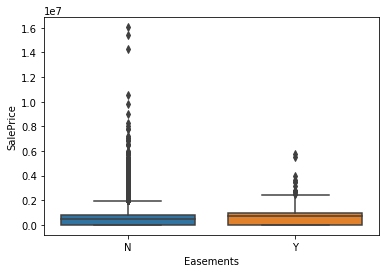

In [29]:
sns.boxplot(x='Easements', y="SalePrice", data=total_df, showfliers=True)

<AxesSubplot:xlabel='Stories', ylabel='SalePrice'>

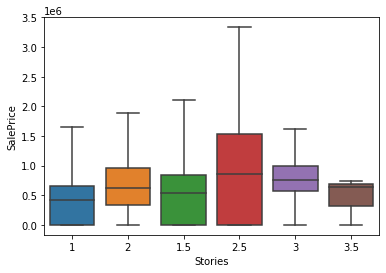

In [30]:
show_box(total_df, 'Stories')

<AxesSubplot:xlabel='InadequateParking', ylabel='SalePrice'>

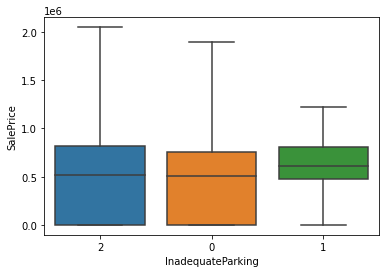

In [31]:
show_box(total_df, 'InadequateParking')

<AxesSubplot:xlabel='TrafficNoise', ylabel='SalePrice'>

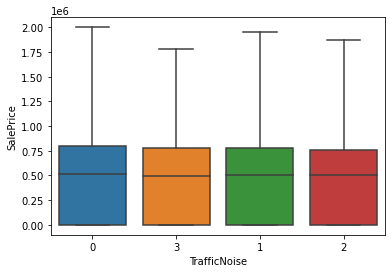

In [32]:
show_box(total_df, 'TrafficNoise')

<AxesSubplot:xlabel='AdjacentGreenbelt', ylabel='SalePrice'>

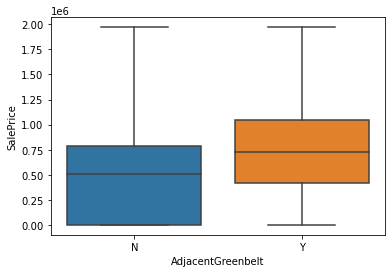

In [33]:
show_box(total_df, 'AdjacentGreenbelt')

<AxesSubplot:xlabel='Access', ylabel='SalePrice'>

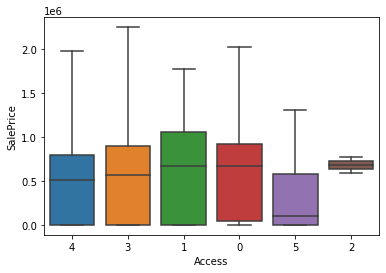

In [34]:
show_box(total_df, 'Access')

<AxesSubplot:xlabel='HeatSystem', ylabel='SalePrice'>

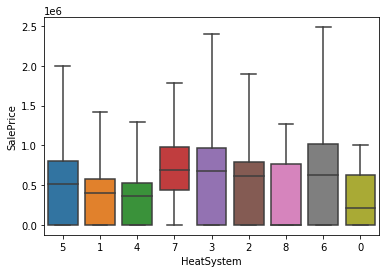

In [35]:
ax = show_box(total_df, 'HeatSystem')
ax

In [36]:
len(total_df)

25502

In [37]:
total_df.PropertyType.value_counts()

11    25502
Name: PropertyType, dtype: int64

In [38]:
total_df = total_df[total_df['SalePrice']!=0]

In [39]:
from geopy.geocoders import Nominatim
locator = Nominatim(user_agent='myGeocoder')
location = locator.geocode('2435  S  354TH                     ST       , KING COUNTY, WA, USA')
print('Latitude = {}, Longitude = {}'.format(location.latitude, location.longitude))

Latitude = 47.28493, Longitude = -122.30216590825634


In [40]:
# # 1 - conveneint function to delay between geocoding calls
# geocode = RateLimiter(locator.geocode, min_delay_seconds=1)
# # 2- - create location column
# total_df['location'] = total_df['address'].apply(geocode)
# # 3 - create longitude, laatitude and altitude from location column (returns tuple)
# total_df['point'] = total_df['location'].apply(lambda loc: tuple(loc.point)\
#                                                              if loc else None)
# # 4 - split point column into latitude, longitude and altitude columns
# total_df[['latitude', 'longitude', 'altitude']] = pd.DataFrame(total_df['point'].\
#                                                                       tolist(), index=total_df.\
#                                                                       index)

In [42]:
# total_df.to_csv('longslats.csv')